<a href="https://colab.research.google.com/github/Nayim-Imrit/imageEnhancement-imageSegmentation/blob/main/ImageEnhancement_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
#1) Image-Enhancement : CLACHE
!pip install pydicom
import matplotlib.pyplot as plt
import pydicom
import os
import cv2
import numpy as np

np.set_printoptions(threshold=np.inf)

     |████████████████████████████████| 2.0 MB 4.3 MB/s 


In [51]:
path = "/content/SkinImages"
files = os.listdir(path)
print(files)

['dermIS_SSM1_orig.jpg', 'dermquest_LMM2_orig.jpg', 'dermIS_AMM1_orig.jpg', 'dermIS_NM1_orig.jpg', 'dermquest_NM61_orig.jpg', 'dermquest_SSM1_orig.jpg', 'notmelanoma_dermquest_D39_2_orig.jpg', 'notmelanoma_dermIS_11_orig.jpg', 'dermIS_LMM1_orig.jpg']


In [52]:
import matplotlib.pyplot as plt
import cv2
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)

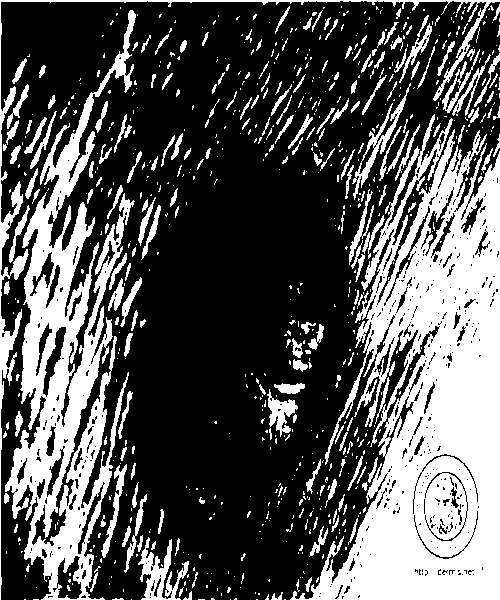

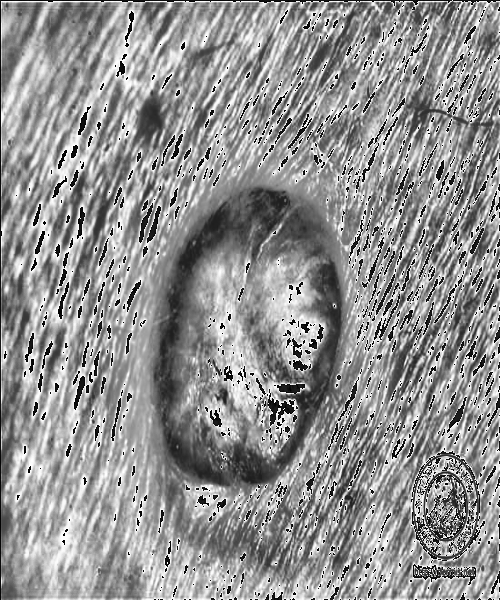

In [53]:
from google.colab.patches import cv2_imshow
import numpy as np
 
# Reading the image from the present directory
image = cv2.imread("/content/SkinImages/dermIS_SSM1_orig.jpg")
# Resizing the image for compatibility
image = cv2.resize(image, (500, 600))

# The initial processing of the image
# image = cv2.medianBlur(image, 3)
image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# The declaration of CLAHE
# clipLimit -> Threshold for contrast limiting
clahe = cv2.createCLAHE(clipLimit = 5)
final_img = clahe.apply(image_bw) + 30

# Ordinary thresholding the same image
_, ordinary_img = cv2.threshold(image_bw, 155, 255, cv2.THRESH_BINARY)

# Showing all the three images
cv2_imshow(ordinary_img) #original img
cv2_imshow(final_img) #Clache applied

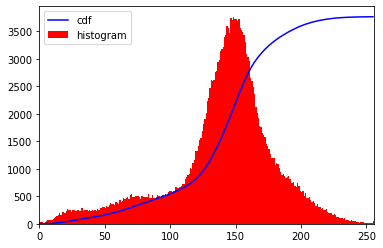

In [54]:
#2) Image-Enhancement : Histogram Equalization
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread("/content/SkinImages/dermIS_SSM1_orig.jpg",0)
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [55]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

In [56]:
img2 = cdf[img]

In [57]:
img = cv.imread("/content/SkinImages/dermIS_SSM1_orig.jpg",0)
equ = cv.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side
cv.imwrite('res.png',res)

True

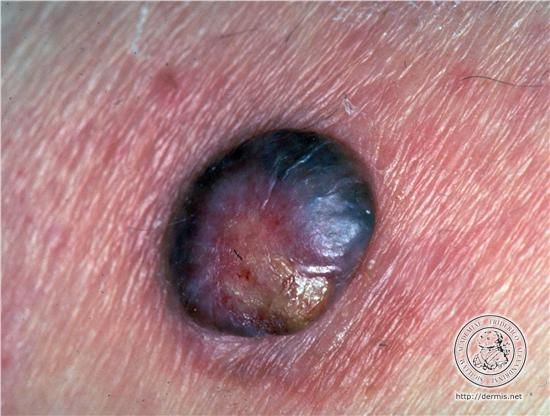

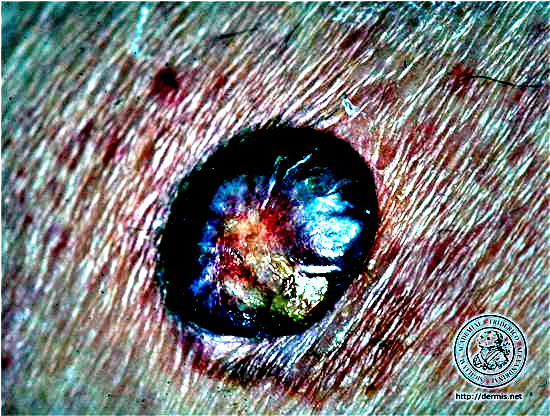

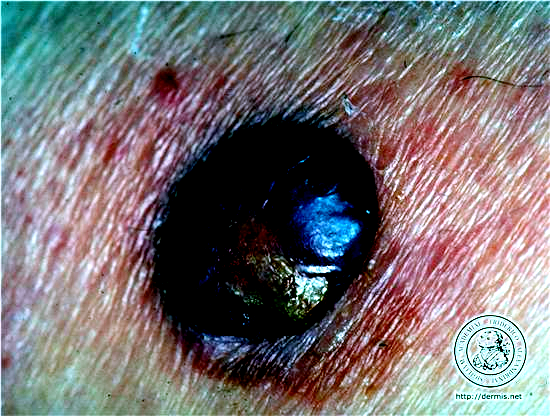

True

In [58]:
#3) Image-Enhancement : Retinex
import numpy as np
from google.colab.patches import cv2_imshow

def singleScaleRetinex(img,variance):
    retinex = np.log10(img) - np.log10(cv2.GaussianBlur(img, (0, 0), variance))
    return retinex

def multiScaleRetinex(img, variance_list):
    retinex = np.zeros_like(img)
    for variance in variance_list:
        retinex += singleScaleRetinex(img, variance)
    retinex = retinex / len(variance_list)
    return retinex



def MSR(img, variance_list):
    img = np.float64(img) + 1.0
    img_retinex = multiScaleRetinex(img, variance_list)

    for i in range(img_retinex.shape[2]):
        unique, count = np.unique(np.int32(img_retinex[:, :, i] * 100), return_counts=True)
        for u, c in zip(unique, count):
            if u == 0:
                zero_count = c
                break            
        low_val = unique[0] / 100.0
        high_val = unique[-1] / 100.0
        for u, c in zip(unique, count):
            if u < 0 and c < zero_count * 0.1:
                low_val = u / 100.0
            if u > 0 and c < zero_count * 0.1:
                high_val = u / 100.0
                break            
        img_retinex[:, :, i] = np.maximum(np.minimum(img_retinex[:, :, i], high_val), low_val)
        
        img_retinex[:, :, i] = (img_retinex[:, :, i] - np.min(img_retinex[:, :, i])) / \
                               (np.max(img_retinex[:, :, i]) - np.min(img_retinex[:, :, i])) \
                               * 255
    img_retinex = np.uint8(img_retinex)        
    return img_retinex



def SSR(img, variance):
    img = np.float64(img) + 1.0
    img_retinex = singleScaleRetinex(img, variance)
    for i in range(img_retinex.shape[2]):
        unique, count = np.unique(np.int32(img_retinex[:, :, i] * 100), return_counts=True)
        for u, c in zip(unique, count):
            if u == 0:
                zero_count = c
                break            
        low_val = unique[0] / 100.0
        high_val = unique[-1] / 100.0
        for u, c in zip(unique, count):
            if u < 0 and c < zero_count * 0.1:
                low_val = u / 100.0
            if u > 0 and c < zero_count * 0.1:
                high_val = u / 100.0
                break            
        img_retinex[:, :, i] = np.maximum(np.minimum(img_retinex[:, :, i], high_val), low_val)
        
        img_retinex[:, :, i] = (img_retinex[:, :, i] - np.min(img_retinex[:, :, i])) / \
                               (np.max(img_retinex[:, :, i]) - np.min(img_retinex[:, :, i])) \
                               * 255
    img_retinex = np.uint8(img_retinex)        
    return img_retinex


variance_list=[15, 80, 30]
variance=300
  
img = cv2.imread("/content/SkinImages/dermIS_SSM1_orig.jpg")
img_msr=MSR(img,variance_list)
img_ssr=SSR(img, variance)

cv2_imshow(img) #Oroginal
cv2_imshow(img_msr) #'MSR'
cv2_imshow(img_ssr) #'SSR'
cv2.imwrite('SSR.jpg', img_ssr) #'SSR.jpg'
cv2.imwrite('MSR.jpg', img_msr) #'MSR.jpg'

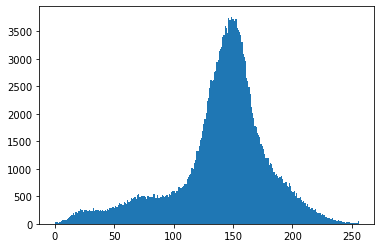

In [59]:
#4) Image-Enhancement : Gamma
!pip install matplotlib
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread("/content/SkinImages/dermIS_SSM1_orig.jpg",0) 
plt.hist(img.ravel(),256,[0,256]) 
plt.show()

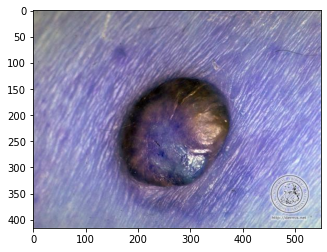

In [60]:
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
badImage = cv2.imread("/content/SkinImages/dermIS_SSM1_orig.jpg") 
plt.imshow(badImage)
plt.show()
def adjust_gamma(image, gamma=1.0):
  table = np.array([((i / 255.0) ** gamma) * 255                      
                    for i in np.arange(0, 256)]).astype("uint8")    
# apply gamma correction using the lookup table    
  return cv2.LUT(image, table) 
  plt.imshow(adjusted)
  plt.show()

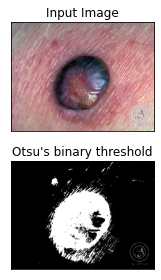

In [61]:
# SEGMENTATION
import numpy as np
import cv2
from matplotlib import pyplot as plt
img = cv2.imread("/content/SkinImages/dermIS_SSM1_orig.jpg")
b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# noise removal
kernel = np.ones((2,2),np.uint8)
#opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(closing,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
# Threshold
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]
plt.subplot(211),plt.imshow(rgb_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(212),plt.imshow(thresh, 'gray')
plt.imsave(r'thresh.png',thresh)
plt.title("Otsu's binary threshold"), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

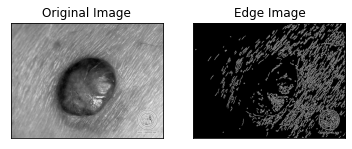

In [62]:
# Code implementation for Sobel operator image Canny:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread("/content/SkinImages/dermIS_SSM1_orig.jpg",0)
edges = cv.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

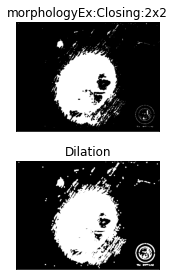

In [63]:
#Code implementation for Watershed segmentation:
# SEGMENTATION
import numpy as np
import cv2
from matplotlib import pyplot as plt
img = cv2.imread("/content/SkinImages/dermIS_SSM1_orig.jpg")
b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.subplot(211),plt.imshow(closing, 'gray')
plt.title("morphologyEx:Closing:2x2"), plt.xticks([]), plt.yticks([])
plt.subplot(212),plt.imshow(sure_bg, 'gray')
plt.imsave(r'dilation.png',sure_bg)
plt.title("Dilation"), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

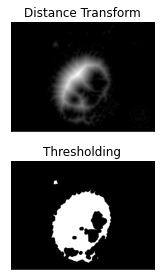

In [64]:
plt.subplot(211),plt.imshow(dist_transform, 'gray')
plt.title("Distance Transform"), plt.xticks([]), plt.yticks([])
plt.subplot(212),plt.imshow(sure_fg, 'gray')
plt.title("Thresholding"), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

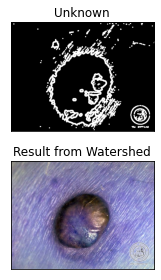

In [65]:
plt.subplot(211),plt.imshow(unknown, 'gray')
plt.title("Unknown"), plt.xticks([]), plt.yticks([])
plt.subplot(212),plt.imshow(img, 'gray')
plt.title("Result from Watershed"), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: No contour levels were found within the data range.


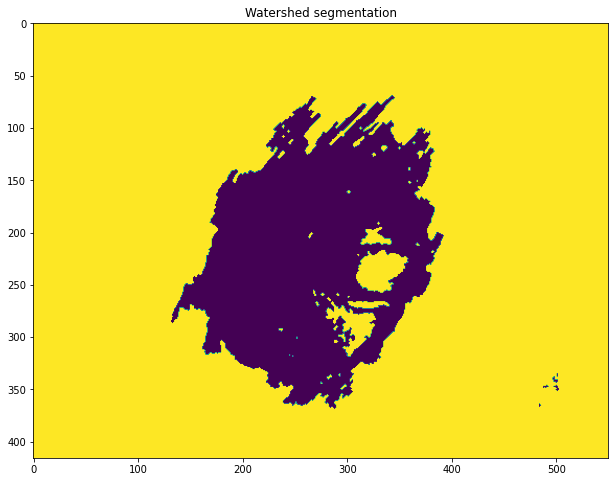

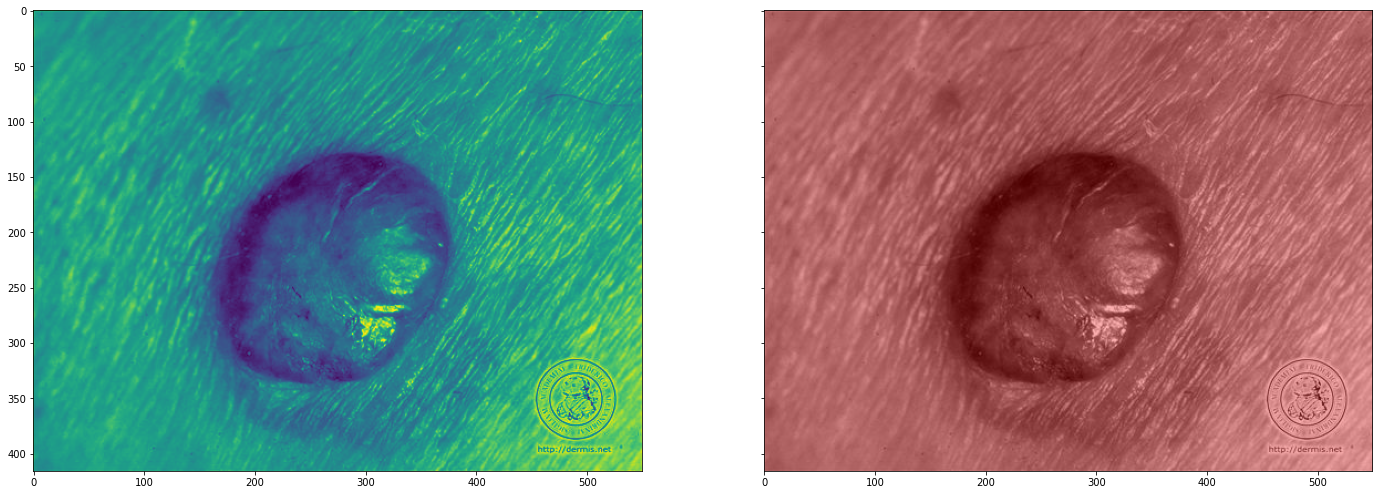

In [66]:
# SEGMENTATION
# Region and Edge Based Segmentation
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import canny
from skimage import data,morphology
from skimage.color import rgb2gray, label2rgb
import scipy.ndimage as nd
from skimage.filters import sobel
plt.rcParams["figure.figsize"] = (12,8)
# %matplotlib inline
 
# load images and convert grayscale
rocket = cv2.imread("/content/SkinImages/dermIS_SSM1_orig.jpg")
rocket_wh = rgb2gray(rocket)
 
# apply edge segmentation
# plot canny edge detection
edges = canny(rocket_wh)
plt.imshow(edges, interpolation='gaussian')
plt.title('Canny detector')
 
# fill regions to perform edge segmentation
fill_im = nd.binary_fill_holes(edges)
plt.imshow(fill_im)
plt.title('Region Filling')
 
# Region Segmentation
# First we print the elevation map
elevation_map = sobel(rocket_wh)
plt.imshow(elevation_map)
 
# Since, the contrast difference is not much. Anyways we will perform it
markers = np.zeros_like(rocket_wh)
markers[rocket_wh < 0.1171875] = 1 # 30/255
markers[rocket_wh > 0.5859375] = 2 # 150/255
 
plt.imshow(markers)
plt.title('markers')
 
# Perform watershed region segmentation
segmentation = morphology.watershed(elevation_map, markers)
 
plt.imshow(segmentation)
plt.title('Watershed segmentation')
 
# plot overlays and contour
segmentation = nd.binary_fill_holes(segmentation - 1)
label_rock, _ = nd.label(segmentation)
# overlay image with different labels
image_label_overlay = label2rgb(label_rock, image=rocket_wh)
 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 16), sharey=True)
ax1.imshow(rocket_wh)
ax1.contour(segmentation, [0.8], linewidths=1.8, colors='w')
ax2.imshow(image_label_overlay)
 
# fig.subplots_adjust(**margins)

In [67]:
# Image Segmentation using K-means
import matplotlib.pyplot as plt
import numpy as np
import cv2
path = "/content/SkinImages/dermIS_SSM1_orig.jpg"
img = cv2.imread(path)

In [68]:
# Preprocessing the Image
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
twoDimage = img.reshape((-1,3))
twoDimage = np.float32(twoDimage)

In [69]:
# Defining Parameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4
attempts=10

Text(0.5, 1.0, 'Segmented image k=4')

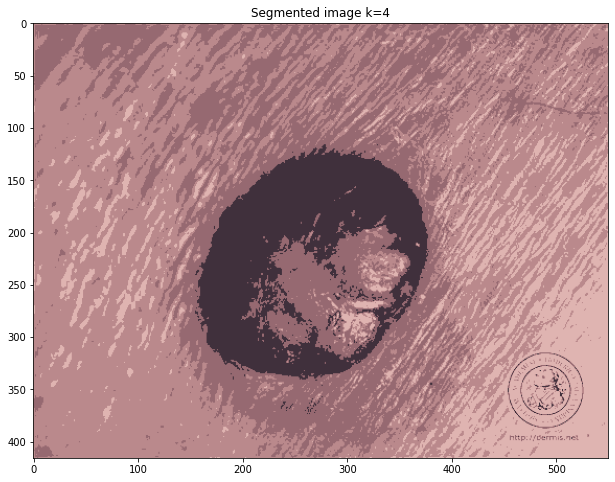

In [71]:
# Apply K-Means
ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
plt.imshow(result_image)
plt.title('Segmented image k=4')

In [72]:
# Segmentation using Color Masking
import cv2
import matplotlib.pyplot as plt
path ="/content/SkinImages/dermIS_SSM1_orig.jpg"
img = cv2.imread(path)

In [73]:
# Preprocessing the Image
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)

In [74]:
# Define the Color Range to be Detected
light_blue = (90, 70, 50)
dark_blue = (128, 255, 255)
#  use the following values for green
# light_green = (40, 40, 40)
# dark_green = (70, 255, 255)
mask = cv2.inRange(hsv_img, light_blue, dark_blue)

Text(0.5, 1.0, 'Segmented image color masking')

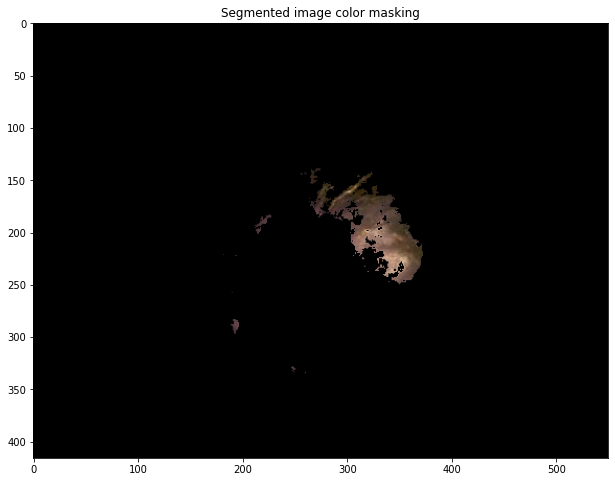

In [75]:
result = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(result)
plt.title('Segmented image color masking')